(Chapter 1: Introductions)=
```{raw} jupyter
<div id="qe-notebook-header" style="text-align:right;">
        <a href="https://quantecon.org/" title="quantecon.org">
                <img style="width:250px;display:inline;" src="https://assets.quantecon.org/img/qe-menubar-logo.svg" alt="QuantEcon">
        </a>
</div>
```
# Chapter 1: Introductions


```{contents} Contents
:depth: 2
```



## two_period_job_search.py

In [1]:
from quantecon.distributions import BetaBinomial

import numpy as np
from numba import njit
from collections import namedtuple


# NamedTuple Model
Model = namedtuple("Model", ("n", "w_vals", "φ", "β", "c"))


def create_job_search_model(
        n=50,        # wage grid size
        w_min=10.0,  # lowest wage
        w_max=60.0,  # highest wage
        a=200,       # wage distribution parameter
        b=100,       # wage distribution parameter
        β=0.96,      # discount factor
        c=10.0       # unemployment compensation
    ):
    """
    Creates the parameters for job search model and returns the
    instance of namedtuple Model
    """
    w_vals = np.linspace(w_min, w_max, n+1)
    φ = BetaBinomial(n, a, b).pdf()
    return Model(n=n, w_vals=w_vals, φ=φ, β=β, c=c)


@njit
def v_1(w, model):
    """
    Computes lifetime value at t=1 given current wage w_1 = w
    """
    β, c = model.β, model.c
    s = np.maximum(c, model.w_vals)
    h_1 = c + β * np.sum(s * model.φ)
    return np.maximum(w + β * w, h_1)


@njit
def res_wage(model):
    """
    Computes reservation wage at t=1
    """
    β, c = model.β, model.c
    s = np.maximum(c, model.w_vals)
    h_1 = c + β * np.sum(s * model.φ)
    return h_1 / (1 + β)



##### Plots #####

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

plt.rcParams.update({"text.usetex": True, "font.size": 14})


default_model = create_job_search_model()


def fig_dist(model=default_model, fs=10):
    """
    Plot the distribution of wages
    """
    fig, ax = plt.subplots()
    ax.plot(model.w_vals, model.φ, "-o", alpha=0.5, label="wage distribution")
    ax.legend(loc="upper left", fontsize=fs)


def fig_v1(model=default_model, savefig=False,
                  figname="./figures/iid_job_search_0_py.pdf", fs=18):
    """
    Plot two-period value function and res wage
    """
    n, w_vals, φ, β, c = model

    v = [v_1(w, model) for w in w_vals]
    w_star = res_wage(model)
    s = np.maximum(c, w_vals)
    continuation_val = c + β * np.sum(s * φ)
    min_w, max_w = np.min(w_vals), np.max(w_vals)

    fontdict = {'fontsize': 10}
    fig, ax = plt.subplots(figsize=(9, 5.5))
    ax.set_ylim(0, 120)
    ax.set_xlim(min_w, max_w)
    ax.vlines((w_star,), (0,), (continuation_val,), lw=0.5)
    ax.set_yticks((0, 50, 100))
    ax.set_yticklabels((0, 50, 100), fontdict=fontdict)
    ax.set_xticks((min_w, w_star, max_w))
    ax.set_xticklabels((min_w, r"$w^*_1$", max_w), fontdict=fontdict)
    ax.plot(w_vals, w_vals + β * w_vals, alpha=0.8, linewidth=3,
            label=r"$w_1 + \beta w_1$")
    ax.plot(w_vals, [continuation_val]*(n+1), linewidth=3, alpha=0.8,
            label=r"$c + \beta \sum_{w'} \max\{c, w'\} \varphi(w')$" )
    ax.plot(w_vals, v, "k--", markersize=2, alpha=1.0, linewidth=2,
            label=r"$v_1(w_1)$")
    ax.legend(frameon=False, fontsize=fs, loc="upper left")
    if savefig:
        fig.savefig(figname)


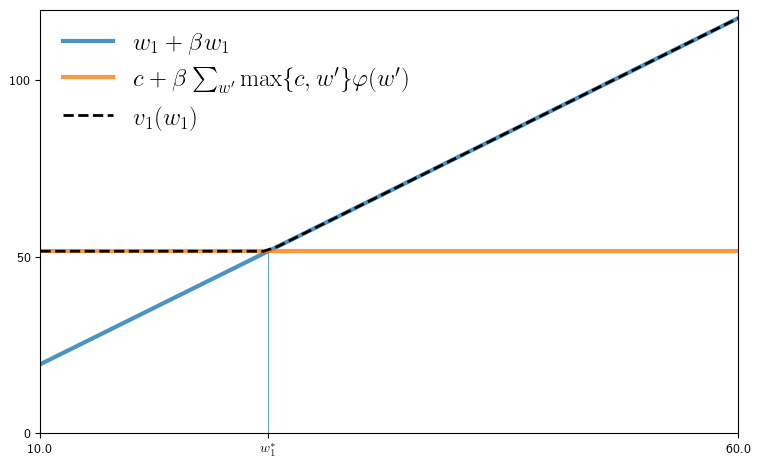

In [2]:
fig_v1()

## compute_spec_rad.py

In [3]:
import numpy as np

# Spectral radius
ρ = lambda A: np.max(np.abs(np.linalg.eigvals(A)))

# Test with arbitrary A
A = np.array([
    [0.4, 0.1],
    [0.7, 0.2]
])
print(ρ(A))


0.5828427124746189


## power_series.py

In [4]:
import numpy as np

# Primitives
A = np.array([
    [0.4, 0.1],
    [0.7, 0.2]
])


# Method one: direct inverse
I = np.identity(2)
B_inverse = np.linalg.inv(I - A)


# Method two: power series
def power_series(A):
    B_sum = np.zeros((2, 2))
    A_power = np.identity(2)
    for k in range(50):
        B_sum += A_power
        A_power = np.dot(A_power, A)
    return B_sum


# Print maximal error
print(np.max(np.abs(B_inverse - power_series(A))))


5.6210591736771676e-12


## s_approx.py

In [5]:
"""
Computes the approximate fixed point of T via successive approximation.
"""

import numpy as np

def successive_approx(T,                     # Operator (callable)
                      x_0,                   # Initial condition
                      tolerance=1e-6,        # Error tolerance
                      max_iter=10_000,       # Max iteration bound
                      print_step=25):        # Print at multiples
    x = x_0
    error = tolerance + 1
    k = 1
    while (error > tolerance) and (k <= max_iter):
        x_new = T(x)
        error = np.max(np.abs(x_new - x))
        if k % print_step == 0:
            print(f"Completed iteration {k} with error {error}.")
        x = x_new
        k += 1
    if error <= tolerance:
        print(f"Terminated successfully in {k} iterations.")
    else:
        print("Warning: hit iteration bound.")
    return x


## linear_iter.py

In [6]:
from s_approx import successive_approx
import numpy as np

# Compute the fixed point of Tx = Ax + b via linear algebra
A = np.array([
    [0.4, 0.1],
    [0.7, 0.2]
])

b = np.array([
    [1.0],
    [2.0]
])

I = np.identity(2)
x_star = np.linalg.solve(I - A, b)  # compute (I - A)^{-1} * b


# Compute the fixed point via successive approximation
T = lambda x: np.dot(A, x) + b
x_0 = np.array([
    [1.0],
    [1.0]
])
x_star_approx = successive_approx(T, x_0)

# Test for approximate equality (prints "True")
print(np.allclose(x_star, x_star_approx, rtol=1e-5))


Completed iteration 25 with error 2.911659384707832e-06.
Terminated successfully in 28 iterations.
True


## linear_iter_fig.py

In [7]:
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

plt.rcParams.update({"text.usetex": True, "font.size": 14})
import numpy as np

from linear_iter import x_star, T

def plot_main(savefig=False, figname="./figures/linear_iter_fig_1.pdf"):

    fig, ax = plt.subplots()

    e = 0.02

    marker_size = 60
    fs = 10

    colors = ("red", "blue", "orange", "green")
    u_0_vecs = ([[2.0], [3.0]], [[3.0], [5.2]], [[2.4], [3.6]], [[2.6], [5.6]])
    u_0_vecs = list(map(np.array, u_0_vecs))
    iter_range = 8

    for (x_0, color) in zip(u_0_vecs, colors):
        x = x_0
        s, t = x
        ax.text(s+e, t-4*e, r"$u_0$", fontsize=fs)

        for i in range(iter_range):
            s, t = x
            ax.scatter((s,), (t,), c=color, alpha=0.2, s=marker_size)
            x_new = T(x)
            s_new, t_new = x_new
            ax.plot((s, s_new), (t, t_new), marker='.',linewidth=0.5, alpha=0.5, color=color)
            x = x_new

    s_star, t_star = x_star
    ax.scatter((s_star,), (t_star,), c="k", s=marker_size * 1.2)
    ax.text(s_star-4*e, t_star+4*e, r"$u^*$", fontsize=fs)

    ax.set_xticks((2.0, 2.5, 3.0))
    ax.set_yticks((3.0, 4.0, 5.0, 6.0))
    ax.set_xlim(1.8, 3.2)
    ax.set_ylim(2.8, 6.1)

    if savefig:
        fig.savefig(figname)


Completed iteration 25 with error 2.911659384707832e-06.
Terminated successfully in 28 iterations.
True


## iid_job_search.py

In [8]:
"""
VFI approach to job search in the infinite-horizon IID case.

"""

from quantecon import compute_fixed_point

from two_period_job_search import create_job_search_model

from numba import njit
import numpy as np


# A model with default parameters
default_model = create_job_search_model()


@njit
def T(v, model):
    """ The Bellman operator. """
    n, w_vals, φ, β, c = model
    return np.array([np.maximum(w / (1 - β),
                    c + β * np.sum(v * φ)) for w in w_vals])


@njit
def get_greedy(v, model):
    """ Get a v-greedy policy. """
    n, w_vals, φ, β, c = model
    σ = w_vals / (1 - β) >= c + β * np.sum(v * φ)  # Boolean policy vector
    return σ


def vfi(model=default_model):
    """ Solve the infinite-horizon IID job search model by VFI. """
    v_init = np.zeros_like(model.w_vals)
    v_star = compute_fixed_point(lambda v: T(v, model), v_init,
                                 error_tol=1e-5, max_iter=1000, print_skip=25)
    σ_star = get_greedy(v_star, model)
    return v_star, σ_star



# == Plots == #

import matplotlib.pyplot as plt
import matplotlib.pyplot as plt

plt.rcParams.update({"text.usetex": True, "font.size": 14})


def fig_vseq(model=default_model,
                k=3,
                savefig=False,
                figname="./figures/iid_job_search_1.pdf",
                fs=10):

    v = np.zeros_like(model.w_vals)
    fig, ax = plt.subplots(figsize=(9, 5.5))
    for i in range(k):
        ax.plot(model.w_vals, v, linewidth=3, alpha=0.6,
                label=f"iterate {i}")
        v = T(v, model)

    for i in range(1000):
        v = T(v, model)

    ax.plot(model.w_vals, v, "k-", linewidth=3.0,
            label="iterate 1000", alpha=0.7)

    fontdict = {'fontsize': fs}
    ax.set_xlabel("wage offer", fontdict=fontdict)
    ax.set_ylabel("lifetime value", fontdict=fontdict)

    ax.legend(fontsize=fs, frameon=False)

    if savefig:
        fig.savefig(figname)


def fig_vstar(model=default_model,
              savefig=False, fs=10,
              figname="./figures/iid_job_search_3.pdf"):
    """ Plot the fixed point. """
    n, w_vals, φ, β, c = model
    v_star, σ_star = vfi(model)

    fig, ax = plt.subplots(figsize=(9, 5.5))
    ax.plot(w_vals, v_star, "k-", linewidth=1.5, label="value function")
    cont_val = c + β * np.sum(v_star * φ)
    ax.plot(w_vals, [cont_val]*(n+1),
            "--",
            linewidth=5,
            alpha=0.5,
            label="continuation value")

    ax.plot(w_vals,
            w_vals / (1 - β),
            "--",
            linewidth=5,
            alpha=0.5,
            label=r"$w/(1 - \beta)$")

    ax.legend(frameon=False, fontsize=fs, loc="lower right")

    if savefig:
        fig.savefig(figname)


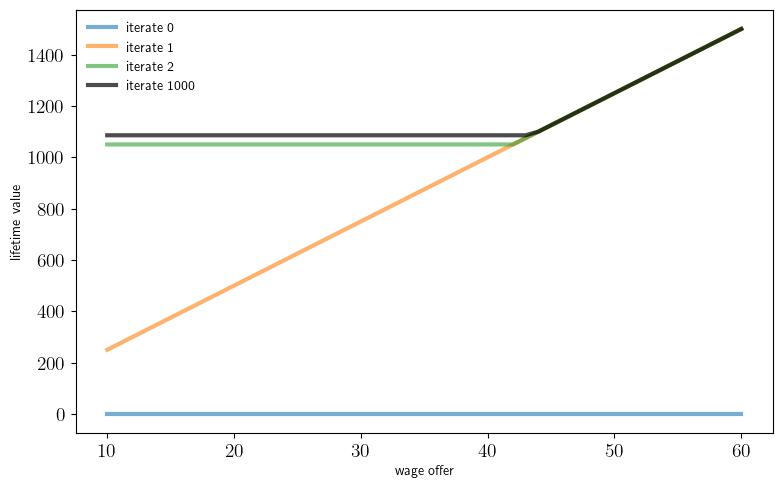

In [9]:
fig_vseq()

Iteration    Distance       Elapsed (seconds)
---------------------------------------------
23           9.192e-06      3.468e-03         
Converged in 23 steps


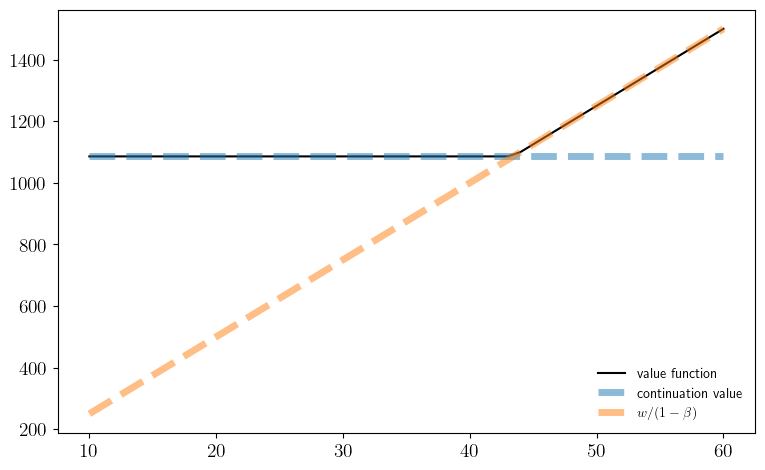

In [10]:
fig_vstar()